# Lab 1: Comparison of the Tensile Properties of the Collateral Ligaments

## Data Analysis

Goals for this lab report:

- **Hypotheses:** What is the effect of the test variable (MCL vs LCL) on
  - Stiffness, $k$
  - Tangent Elastic Modulus, $E$
- Present $\text{mean}\pm\text{std. dev.}$ and perform statistical tests for:
  - Geometric Dimensions: $L_0$, $w$, $t$
  - Cross-sectional area, $A$
  - Stiffness, $k$ (T-Test)
  - Tangend Elastic Modulus, $E$ (T-Test)

In [1]:
# Google Colab: Run this to mount your Google Drive

# from google.colab import drive
# import os
# drive.mount('/content/gdrive', force_remount=True)
# os.chdir('/content/gdrive/MyDrive/BMES 301/Lab 1')

In [2]:
# Notebook setup

%load_ext autoreload
%autoreload 2

## Import necessary libraries
from pathlib import Path
from scipy import stats
import plotly.graph_objects as go
import plotly.express as px
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import pandas as pd
import numpy as np
import tools
import re
import os

## Define the paths to raw data and results
datapath = Path('data')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [116]:
# Load data

## Regular expression to pull sample and team information from file name
meta = re.compile(r"(?P<tissue>[ml]cl)(?P<team>\d{2})")

## Load all data into a list
data = []
for file in datapath.glob("lab1*.csv"):

    ## Extract sample and team information from file name
    match = meta.search(file.name)

    ## Load data
    try:
        _df = tools.load_data(file)
        _df['tissue'] = match.group('tissue').upper()
        _df['team'] = match.group('team')
        data.append(_df)
    except AssertionError as e:
        print(f"Error loading {file.name}: {e}")

## Concatenate all data into a single dataframe
data = pd.concat(data).reset_index(drop=True)
display(data.head())

## Load specimen dimensions
specimen = pd.read_excel(datapath / 'lab1_specimen_dimensions.xlsx')

,time,disp,load,tissue,team
0,0.0000,-2.000079,-0.08,LCL,01
1,0.1464,-1.998455,-0.08,LCL,01
2,0.2928,-1.995375,-0.08,LCL,01
3,0.4392,-1.984185,-0.08,LCL,01
4,0.5856,-1.970243,-0.08,LCL,01


## Raw Data Visualization

**Preconditioning:** $t > 120s$

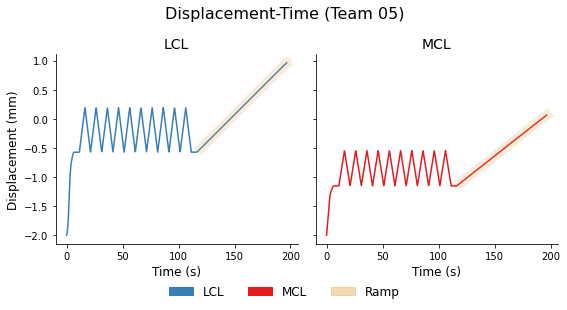

In [117]:
# Disp vs Time
fig, ax = tools.plot_data(
    data = data.copy(),
    xvar='time',
    yvar='disp',
    xlab='Time (s)',
    ylab='Displacement (mm)',
    title='Displacement-Time (Team 05)',
    highlight_ramp=True,
    ramp_time=120
)

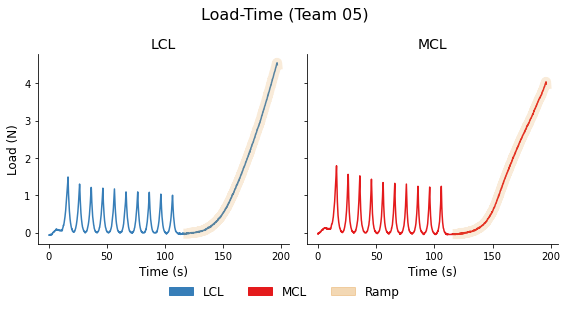

In [118]:
# Load vs Time
fig, ax = tools.plot_data(
    data = data.copy(),
    xvar='time',
    yvar='load',
    xlab='Time (s)',
    ylab='Load (N)',
    title='Load-Time (Team 05)',
    highlight_ramp=True,
    ramp_time=120
)

## Visualization: Stress & Strain

$$ \text{Stress, } \sigma = \frac{F}{w \cdot t} $$

$$ \text{Strain, } \varepsilon = \frac{\Delta L}{L_0} $$

Figures from this point only include the 'ramp' data.

In [119]:
# Exclude preconditioning data and shift displacement to start at 0
data = data.loc[data['time'] > 120].copy()

# Shift displacement and time to start at 0 (Done separately for each team)
for team in data['team'].unique():
    I = data['team'] == team
    data.loc[I, 'disp'] = (data.loc[I]
        .groupby('tissue')['disp']
        .apply(lambda x: x - x.iloc[0]))
    data.loc[I, 'time'] = (data.loc[I]
        .groupby('tissue')['time']
        .apply(lambda x: x - x.iloc[0]))

In [120]:
# Compute stress and strain
for team in data['team'].unique():
    for tissue in ['MCL', 'LCL']:
        I = (data['team'] == team) & (data['tissue'] == tissue)
        J = (specimen['Group #'] == int(team)) & (specimen['Ligament'] == tissue)

        # Stress
        A = (specimen.loc[J, 'Width (mm)'] * specimen.loc[J, 'Thickness (mm)']).values[0]
        data.loc[I, 'stress'] = data.loc[I, 'load'] / A

        # Strain
        L0 = specimen.loc[J, 'Gauge length (mm)'].values[0]
        data.loc[I, 'strain'] = data.loc[I, 'disp'] / L0

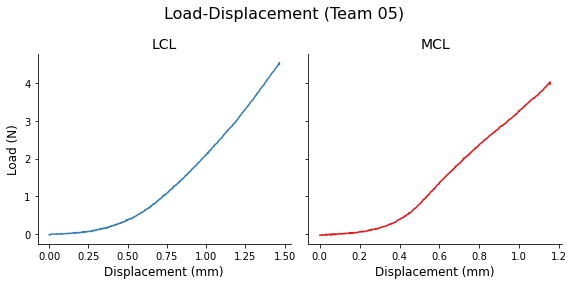

In [121]:
# Load vs Displacement
fig, ax = tools.plot_data(
    data = data.copy(),
    xvar='disp',
    yvar='load',
    xlab='Displacement (mm)',
    ylab='Load (N)',
    title='Load-Displacement (Team 05)',
    highlight_ramp=False
)

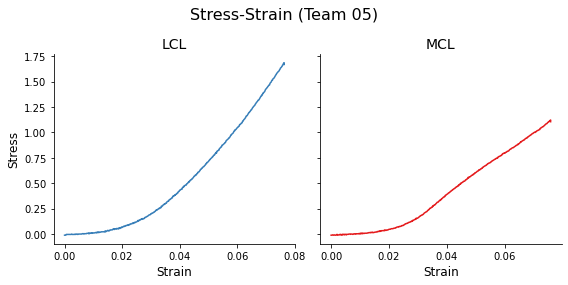

In [122]:
# Stress vs Strain
fig, ax = tools.plot_data(
    data = data.copy(),
    xvar='strain',
    yvar='stress',
    xlab='Strain',
    ylab='Stress',
    title='Stress-Strain (Team 05)',
    highlight_ramp=False
)

## Curve Fitting: Estimate $E$ and $k$


$$ \sigma = E \cdot \varepsilon $$
$$ F = k\cdot \Delta L $$
$$ k = \frac{E \cdot A}{L_0} $$

In [124]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [139]:
import statsmodels.formula.api as smf

In [158]:
# Loop until convergence


def get_linear_region(data):
    """
    Determing the linear region of the stress-strain curve

    The linear region is defined as the region where the slope of the stress-strain 
    curve is constant. This is determined by removing one data point, fitting 
    the model and checking the R^2 value. This process is repeated, removing 
    one data point at a time, until the R^2 values converge. 
    The loop is terminated if more than 30% of the data is removed
    """

    i, r2, flag = 0, [], True
    n = data.shape[0]

    while flag:
        if i < 0.3 * n:
            print("R^2 didn't converge after 30% of the data was removed")
            break

        # Fit model
        model = smf.ols('stress ~ strain', data=data.loc[I][i:])
        model = model.fit()

        # Compute R^2
        r2.append(model.rsquared)

        # Check for convergence
        if i > 0:
            if abs(r2[-1] - r2[-2]) < 1e-4:
                flag = False

        i += 1

    return i-1, max(r2)

In [159]:
I = (data['team'] == '05') & (data['tissue'] == 'MCL')

model = smf.ols('stress ~ strain', data=data.loc[I])
model = model.fit()

In [160]:
d = data.loc[I].copy()

In [162]:
i = get_linear_region(d)

R^2 didn't converge after 30% of the data was removed


156.29999999999998

In [148]:
data.loc[I][2:]

,time,disp,load,tissue,team,stress,strain
19542,0.2928,0.004181,-0.04,MCL,05,-0.011111,0.000275
19543,0.4392,0.006521,-0.03,MCL,05,-0.008333,0.000429
19544,0.5856,0.008683,-0.03,MCL,05,-0.008333,0.000571
19545,0.7320,0.010997,-0.04,MCL,05,-0.011111,0.000723
19546,0.8784,0.013060,-0.04,MCL,05,-0.011111,0.000859
...,...,...,...,...,...,...,...
20056,75.5424,1.147897,4.00,MCL,05,1.111111,0.075520
20057,75.6888,1.150149,4.02,MCL,05,1.116667,0.075668
20058,75.8352,1.152362,4.02,MCL,05,1.116667,0.075813
20059,75.9816,1.154342,4.04,MCL,05,1.122222,0.075944


In [134]:
regr.coef_

array([[16.44469665]])

In [22]:
# Select linear region
I = df['Elapsed Time (s)'] > 120
fig = px.scatter(df[I], x='Displacement (mm)', y='Force (N)')
fig.update_layout(width=700, height=350)

In [23]:
# For analysis, show 
force = df.loc[I, 'Force (N)']
displacement = df.loc[I, 'Displacement (mm)']  # Is this the right value for Delta L
res = stats.linregress(displacement, force)

print(f"Slope: {res.slope:.4f} +/- {res.stderr:.4f}")

Slope: 5.8759 +/- 0.0637


In [24]:
%load_ext rpy2.ipython

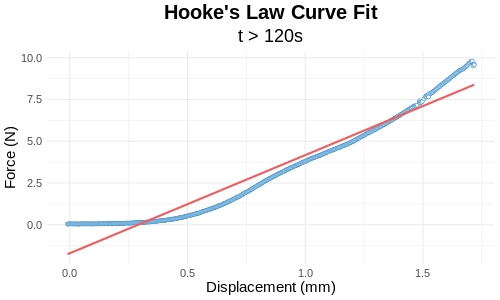

In [82]:
%%R -i df -w 500 -h 300
require(tidyverse)


df %>%
    filter(`Elapsed Time (s)` > 120) %>%
    ggplot(aes(x=`Displacement (mm)`, y=`Force (N)`)) +
        geom_point(color='#4c98cf', fill='white', shape=21) +
        geom_smooth(method='lm', formula='y~x', se=FALSE, color='#f05d5d', 
                    linewidth=4) +
        theme_minimal() +
        labs(title="Hooke's Law Curve Fit", subtitle='t > 120s') +
        theme(
            plot.title=element_text(hjust=0.5, size=20, face='bold'),
            plot.subtitle=element_text(hjust=0.5, size=18),
            axis.title=element_text(size=15),
            axis.text=element_text(size=11)
        )